In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization
from tensorflow.keras import Model
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [30, 20]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

2022-08-15 01:04:25.266849: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-15 01:04:25.266875: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#from tensorflow.keras.regularizers import l2
#from tensorflow.keras.regularizers import l1

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Dataset params
num_classes = 10
size = x_train.shape[1]

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

Train set:    60000 samples
Test set:     10000 samples
Sample dims:  (60000, 28, 28)


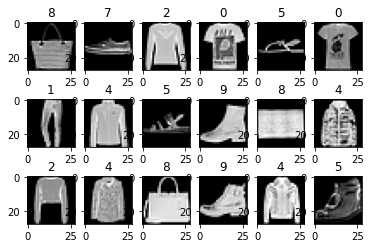

In [4]:
cnt = 1
for r in range(3):
    for c in range(6):
        idx = np.random.randint(len(x_train))
        plt.subplot(3,6,cnt)
        plt.imshow(x_train[idx, ...], cmap='gray')
        plt.title(y_train[idx])
        cnt = cnt + 1

In [5]:
# Data normalization
x_train = x_train/255
x_test = x_test/255

In [6]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
        
    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])

In [7]:
from sklearn.utils import shuffle

def datagen(x, y, batch_size):
    num_samples = len(y)
    while True:
        for idx in range(0, num_samples, batch_size):
            x_ = x[idx:idx + batch_size, ...]
            y_ = y[idx:idx + batch_size]
            
            if len(y_) < batch_size:
                x, y = shuffle(x, y)
                break
            
            # Augmentation
            for idx_aug in range(batch_size):
                if np.random.rand() > 0.2:
                    x_[idx_aug, ...] = np.fliplr(x_[idx_aug, ...])                                
                if np.random.rand() > 0.2:
                    x_[idx_aug, ...] = np.flipud(x_[idx_aug, ...])  
                #if np.random.rand() > 0.2:
                    #x_[idx_aug, ...] = np.roll(x_[idx_aug, ...], 1)      
            yield x_, y_

In [8]:
# Modify the baseline classifier in order to reduce the overfitting and make the performance more robust

inputs = Input(shape=(28, 28, 1))
net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same')(inputs)
net = BatchNormalization()(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)
net = BatchNormalization()(net)
net = Flatten()(net)
net = Dense(64)(net)
net = BatchNormalization()(net)
net = Dropout(0.5)(net)
outputs = Dense(10, activation="softmax")(net)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 32)       128   

2022-08-15 01:04:36.227119: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-15 01:04:36.227151: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-15 01:04:36.227166: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Elias): /proc/driver/nvidia/version does not exist
2022-08-15 01:04:36.227327: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
epochs = 33
batch_size = 64

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/33


2022-08-15 01:04:38.725153: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


938/938 [==============================] - 22s 23ms/step - loss: 0.4475 - accuracy: 0.8476 - val_loss: 0.3490 - val_accuracy: 0.8723
Epoch 2/33
938/938 [==============================] - 23s 24ms/step - loss: 0.3303 - accuracy: 0.8858 - val_loss: 0.3196 - val_accuracy: 0.8831
Epoch 3/33
938/938 [==============================] - 22s 23ms/step - loss: 0.3015 - accuracy: 0.8956 - val_loss: 0.2798 - val_accuracy: 0.9005
Epoch 4/33
938/938 [==============================] - 21s 23ms/step - loss: 0.2828 - accuracy: 0.8994 - val_loss: 0.2824 - val_accuracy: 0.9003
Epoch 5/33
938/938 [==============================] - 22s 23ms/step - loss: 0.2730 - accuracy: 0.9041 - val_loss: 0.2877 - val_accuracy: 0.8974
Epoch 6/33
938/938 [==============================] - 22s 23ms/step - loss: 0.2595 - accuracy: 0.9093 - val_loss: 0.2694 - val_accuracy: 0.9034
Epoch 7/33
938/938 [==============================] - 22s 24ms/step - loss: 0.2545 - accuracy: 0.9105 - val_loss: 0.2758 - val_accuracy: 0.9040
Epo

Train Acc      0.9317166805267334
Validation Acc 0.9120000004768372


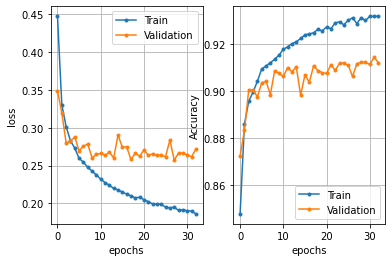

In [10]:
plot_history(history)